# Statistical Analysis of Trajectory Data

In addition to using the OAT library to analyze the data, we will also want to apply some common statistical analysis to the trajectory data provided by oxDNA so that we can compare the results to the output of our GNN. Note that for now I will report all the statistics in simulation units so they can be directly compared with GNN results. Specifically, we want to: 

* Obtain mean, standard deviation, min, max for each feature in the configuration file for each nucleotide over all time steps

* Obtain mean, standard deviation, min, max for the acceleration of each nucleotide over all time steps

* Compute mean, standard deviation, min, max for each feature in the configuration file over all nucleotides and all time steps

* Obtain mean, standard deviation, min, max for the acceleration over all nucleotides and over all time steps

* Compute mean, standard deviation, min, max for the total energy over all time steps

* Compute mean, standard deviation, min, max for the bounding box dimensions over all time steps

* Plot CoM position vs base/base normal vectors as scatter plots for x, y, z

* Plot velocity vs angular vector as scatter plots for x, y, z

## Useful References

* https://dna.physics.ox.ac.uk/index.php/Documentation
* https://dna.physics.ox.ac.uk/index.php/Input_options_of_the_previous_version
* https://dna.physics.ox.ac.uk/index.php/Model_introduction 

## Import Dataset

In [110]:
# import libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [112]:
def importDataset(raw_data_path):
    # import configuration data as np array
    # Thanks Chris Kottke for code snippet

    posAll = []
    baseAll = []
    baseNormalAll = []
    velocityAll = []
    angVelocityAll = []
    bbAll = [] # bounding box data
    energyAll = [] 

    with open(raw_data_path, "r") as f:
        lines = f.readlines()
        pos = []
        base = []
        baseNormal = []
        velocity = []
        angVelocity = []

        for line in tqdm(lines):
            if "t =" in line:
                if len(pos) > 0:
                    # save and reset the frames
                    posAll.append(pos)
                    pos = []
                    baseAll.append(base)
                    base = []
                    baseNormalAll.append(baseNormal)
                    baseNormal = []
                    velocityAll.append(velocity)
                    velocity = []
                    angVelocityAll.append(angVelocity)
                    angVelocity = []

            elif "b =" in line:
                line_list = [float(s) for s in line.split()[2:]]
                bbAll.append(line_list)

            elif "E =" in line:
                line_list = [float(s) for s in line.split()[2:]]
                energyAll.append(line_list)

            else:
                line_list = [float(s) for s in line.split()]
                pos.append(line_list[0:3])
                base.append(line_list[3:6])
                baseNormal.append(line_list[6:9])
                velocity.append(line_list[-6:-3])
                angVelocity.append(line_list[-3:])

    if len(pos) > 0:
        posAll.append(pos)
        baseAll.append(base)
        baseNormalAll.append(baseNormal)
        velocityAll.append(velocity)
        angVelocityAll.append(angVelocity)

    positions = [np.array(posAll, dtype=np.float32)]
    num_particles = len(positions[0][0])
    print("total number of particles", num_particles)
    
    return posAll, baseAll, baseNormalAll, velocityAll, angVelocityAll, bbAll, energyAll

In [113]:
raw_data_path = "/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/trajectory_sim.dat"
posAll, baseAll, baseNormalAll, velocityAll, angVelocityAll, bbAll, energyAll = importDataset(raw_data_path)

100%|█████████████████████████████████| 43000/43000 [00:00<00:00, 148931.19it/s]

total number of particles 40


## Function Definitions

In [4]:
def plotSampleTimeData(data, description):
    """
    Plots some sample trajectories over time.
    
    Inputs:
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    """
    t = np.arange(0, data.shape[0])
    for i in range(0, data.shape[1], 8):
        plt.plot(t, data[:,i,0], label="{0}".format(i))
    plt.xlabel("Time")
    plt.ylabel("X {0}".format(description))
    plt.title("Sample {0} Data".format(description))
    plt.grid()
    plt.legend()
    plt.show()

In [77]:
def computeStatsPer(data, axis=0):
    """
    Calculates mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    axis : int, the axis along which we want to compute the mean (axis = 0 will average over time, axis = 1 over nucleotides)
    """
    mean_per = np.mean(data, axis=axis)
    std_per = np.std(data, axis=axis)
    min_per = np.min(data, axis=axis)
    max_per = np.max(data, axis=axis)
    
    return mean_per, std_per, min_per, max_per

In [78]:
def computeStatsAll(mean_per, std_per, min_per, max_per):
    """
    Calculates mean, standard deviation, min, max for all nucleotides over all time steps for a given dataset.
    
    Inputs: 
    
    mean_per : np array size [n or t, c] where t = time steps, n = number of nucleotides, c = number of axes, contains mean data
    std_per : np array size [n or t, c] where t = time steps, n = number of nucleotides, c = number of axes, contains std data
    min_per : np array size [n or t, c] where t = time steps, n = number of nucleotides, c = number of axes, contains min data
    max_per : np array size [n or t, c] where t = time steps, n = number of nucleotides, c = number of axes, contains max data
    """

    mean_all = np.mean(mean_per, axis=0)
    std_all = np.std(std_per, axis=0)
    min_all = np.min(min_per, axis=0)
    max_all = np.max(max_per, axis=0)
    
    return mean_all, std_all, min_all, max_all

In [93]:
def computePlotStatsPer(data, description, axis=0):
    """
    Calculates and plots mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    axis : int, the axis along which we want to compute the mean (axis = 0 will average over time, axis = 1 over nucleotides)
    """
    
    mean_per, std_per, min_per, max_per = computeStatsPer(data, axis)
    
    x = np.arange(0,mean_per.shape[0])
    
    # mean data
    plt.errorbar(x, mean_per[:,0], yerr=std_per[:,0], fmt="or", label="x")
    plt.errorbar(x, mean_per[:,1], yerr=std_per[:,1], fmt="og", label="y")
    plt.errorbar(x, mean_per[:,2], yerr=std_per[:,2], fmt="ob", label="z")
    
    # min max data
    plt.plot(x, min_per[:,0], "--r", label="min x")
    plt.plot(x, min_per[:,1], "--g", label="min y")
    plt.plot(x, min_per[:,2], "--b", label="min z")
    plt.plot(x, max_per[:,0], "-r", label="max x")
    plt.plot(x, max_per[:,1], "-g", label="max y")
    plt.plot(x, max_per[:,2], "-b", label="max z")

    if axis == 0:
        plt.xlabel("Nucleotide")
        plt.title("Mean {0} per Nucleotide".format(description))
    elif axis == 1:
        plt.xlabel("Time")
        plt.title("Mean {0} per Time Step".format(description))
        
    plt.ylabel("Mean {0}".format(description))
    plt.legend()
    plt.grid()
    plt.show()

In [109]:
def computePlotStatsAll(data, description):
    """
    Calculates and plots mean, standard deviation, min, max for each nucleotide over all time steps for a given dataset.
    
    Inputs: 
    
    data : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    description : str describing the data
    """
        
    mean_per, std_per, min_per, max_per = computeStatsPer(data, axis)
    mean_all, std_all, min_all, max_all = computeStatsAll(mean_per, std_per, min_per, max_per)
    
    x = ("x", "y", "z")
    plt.errorbar(x, mean_all, yerr=std_all, fmt="ob", label="mean")
    plt.plot(x, min_all, label="min")
    plt.plot(x, max_all, label="max")
    plt.xlabel("Nucleotide")
    plt.ylabel("Mean {0}".format(description))
    plt.title("Mean {0} for all Nucleotides".format(description))
    plt.grid()
    plt.legend()
    plt.show()

In [67]:
def plotGradientScatter(mean_d1, mean_d2, coord, data1label, data2label):
    """
    Plot the mean of data 1 and data 2 over one coordinate (x, y, z) using a gradient to plot the points to indicate their evolution over time.
    
    Inputs:
    mean_d1 : np array size [t, c] where t = time steps, c = number of axes
    mean_d2 : np array size [t, c] where t = time steps, c = number of axes
    coord : int, a value in [0, 2] which indicates whether we should plot x, y or z coordinate
    data1label: str, the name of data1
    data2label: str, the name of data2
    """
    
    if coord == 0:
        coord_label = "x"
    elif coord == 1:
        coord_label = "y"
    else:
        coord_label = "z"

    plt.scatter(mean_d1[:,coord], mean_d2[:,coord], c=np.arange(mean_d1.shape[0]), cmap="plasma")
    plt.grid()
    plt.xlabel("{0}".format(data1label))
    plt.ylabel("{0}".format(data2label))
    plt.title("Plot Indicating any Correlation over Time between {0} and {1} in {2}".format(data1label, data2label, coord_label))
    plt.show()

In [68]:
def plotCorrelation(data1, data2, axis, data1label, data2label):
    """
    Compute the mean of data1 and data2 and plot against each other on a scatter plot to look for correlations.
    
    Inputs:
    data1 : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    data2 : np array size [t, n, c] where t = time steps, n = number of nucleotides, c = number of axes
    axis : int, the axis along which we want to compute the mean (axis = 0 will average over time, axis = 1 over nucleotides)
    data1label: str, the name of data1
    data2label: str, the name of data2
    """
    # compute mean data for all particles
    mean_d1, _, _, _ = computeStatsPer(data1, axis=axis)
    mean_d2, _, _, _ = computeStatsPer(data2, axis=axis)
    
    if axis == 0:

        # plot means on scatter plot for x, y, z coordinates
        plt.scatter(mean_d1[:,0], mean_d2[:,0], label="x")
        plt.scatter(mean_d1[:,1], mean_d2[:,1], label="y")
        plt.scatter(mean_d1[:,2], mean_d2[:,2], label="z")
        plt.legend()
        plt.grid()
        plt.xlabel("{0}".format(data1label))
        plt.ylabel("{0}".format(data2label))
        plt.title("Plot Indicating any Correlation over Nucleotides between {0} and {1}".format(data1label, data2label))
        plt.show()
        
    if axis == 1: 
        
        for i in range(data1.shape[2]):
            plotGradientScatter(mean_d1, mean_d2, i, data1label, data2label)

## Trajectory Data Analysis 

In [86]:
posAll = np.array(posAll)
baseAll = np.array(baseAll)
baseNormalAll = np.array(baseNormalAll)
velocityAll = np.array(velocityAll)
angVelocityAll = np.array(angVelocityAll)

print(posAll.shape)
print(baseAll.shape)
print(baseNormalAll.shape)
print(velocityAll.shape)
print(angVelocityAll.shape)

(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)
(1000, 40, 3)


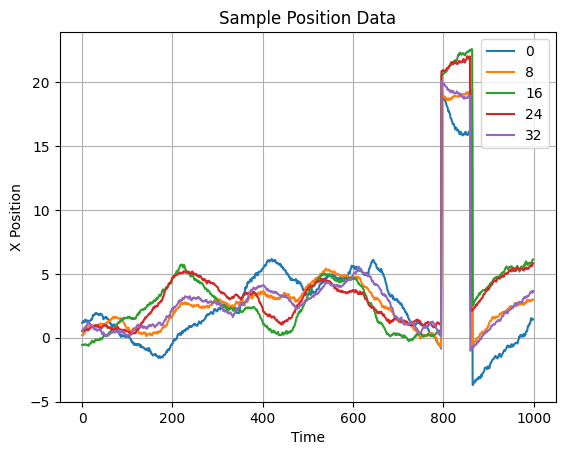

In [26]:
plotSampleTimeData(posAll, "Position")

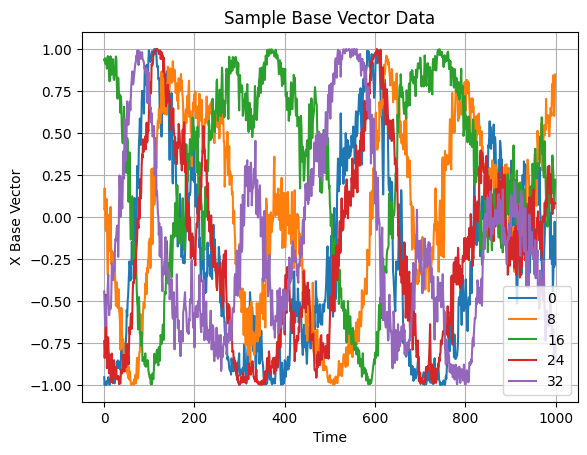

In [79]:
plotSampleTimeData(baseAll, "Base Vector")

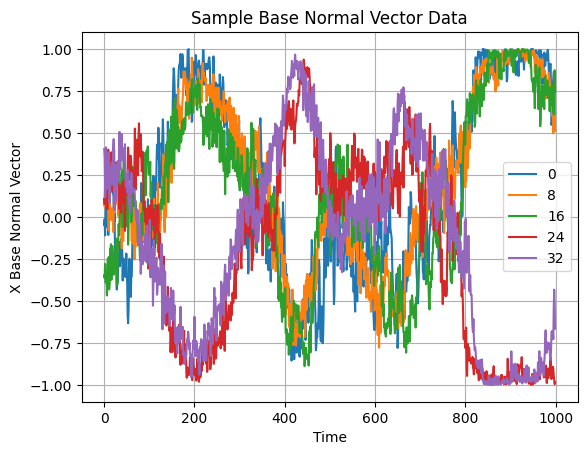

In [80]:
plotSampleTimeData(baseNormalAll, "Base Normal Vector")

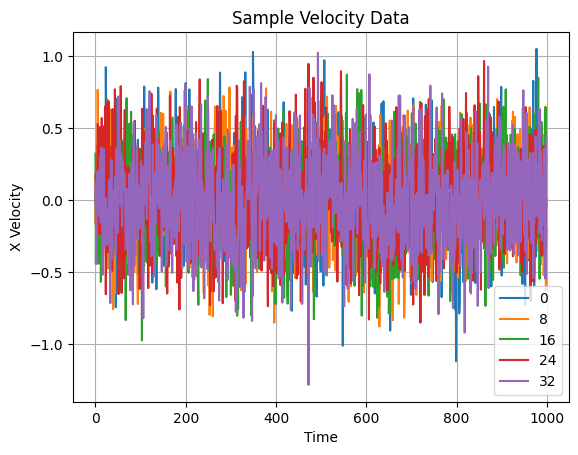

In [81]:
plotSampleTimeData(velocityAll, "Velocity")

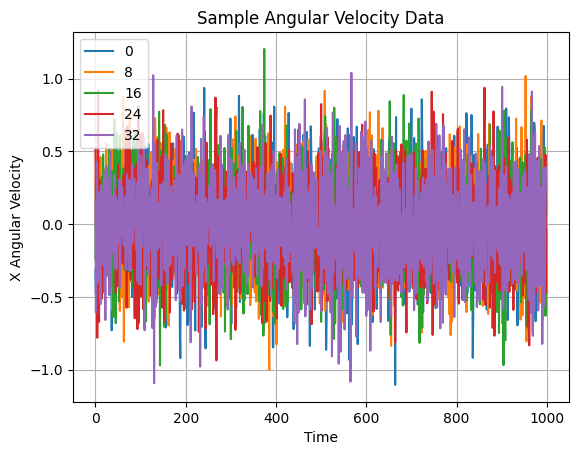

In [82]:
plotSampleTimeData(angVelocityAll, "Angular Velocity")

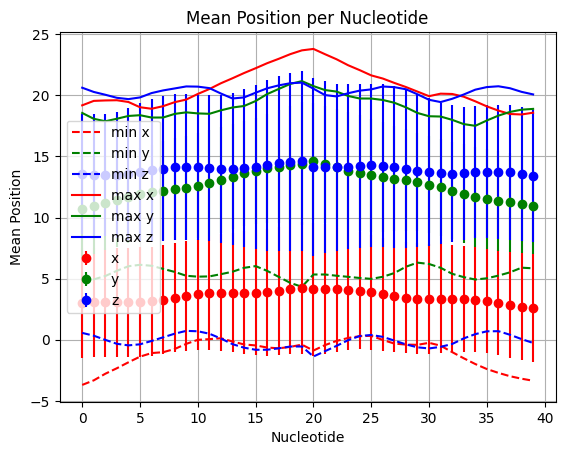

In [95]:
computePlotStatsPer(posAll, "Position")

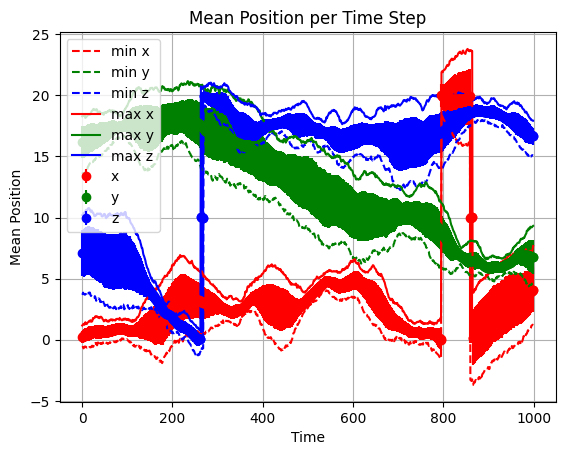

In [97]:
computePlotStatsPer(posAll, "Position", axis=1)

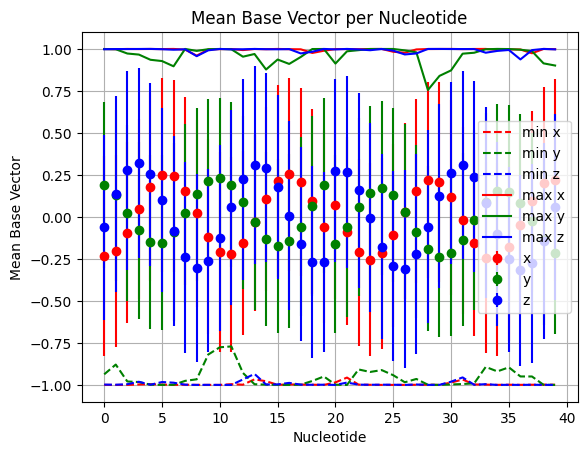

In [99]:
computePlotStatsPer(baseAll, "Base Vector")

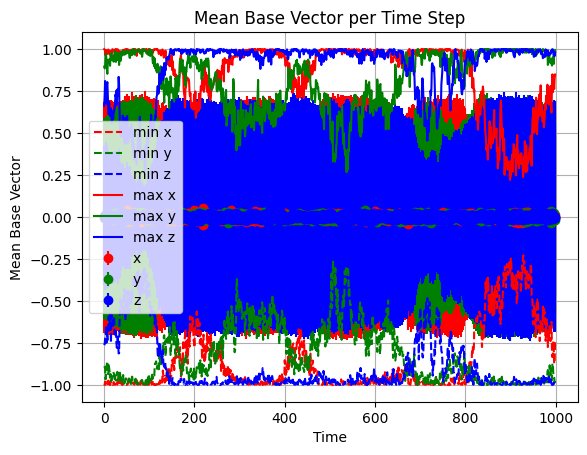

In [100]:
computePlotStatsPer(baseAll, "Base Vector", axis=1)

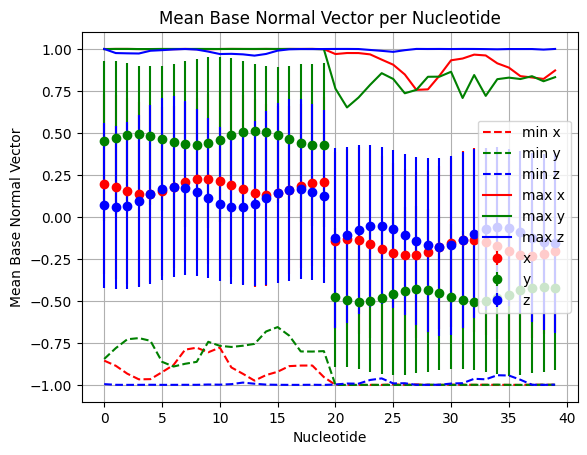

In [101]:
computePlotStatsPer(baseNormalAll, "Base Normal Vector")

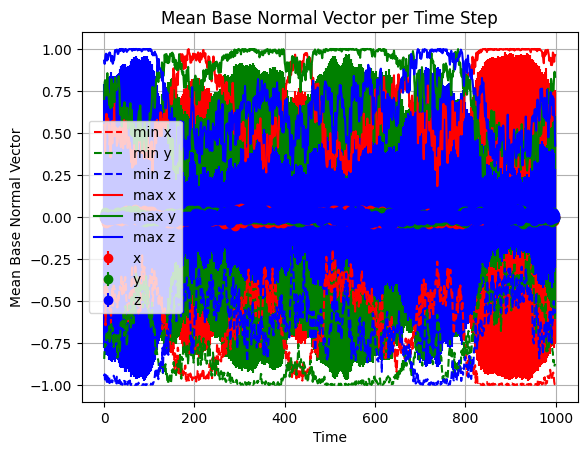

In [102]:
computePlotStatsPer(baseNormalAll, "Base Normal Vector", axis=1)

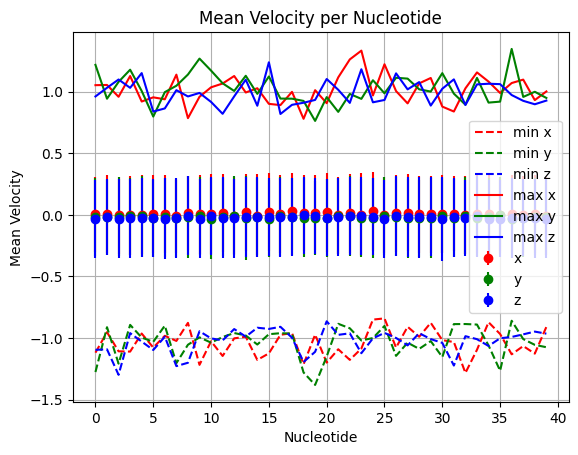

In [103]:
computePlotStatsPer(velocityAll, "Velocity")

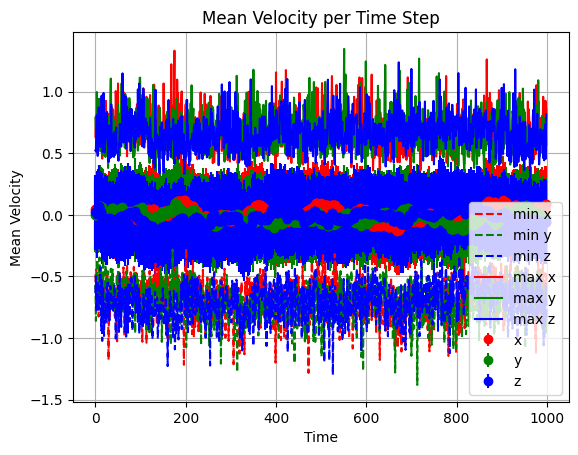

In [104]:
computePlotStatsPer(velocityAll, "Velocity", axis=1)

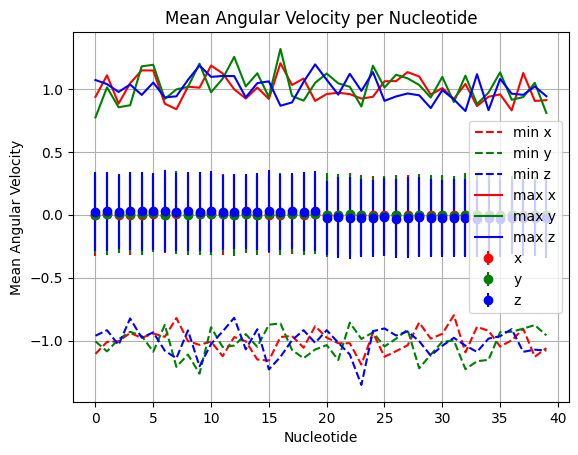

In [105]:
computePlotStatsPer(angVelocityAll, "Angular Velocity")

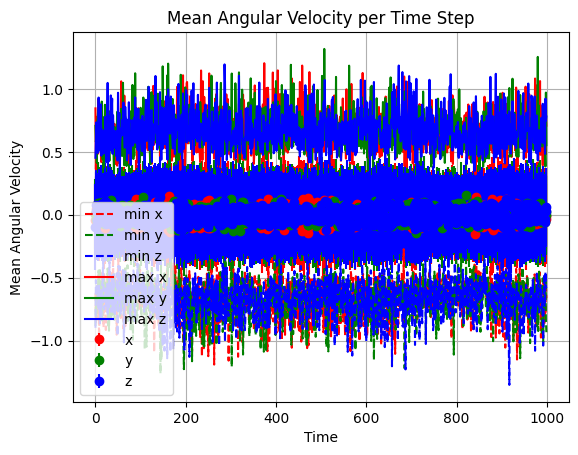

In [106]:
computePlotStatsPer(angVelocityAll, "Angular Velocity", axis=1)

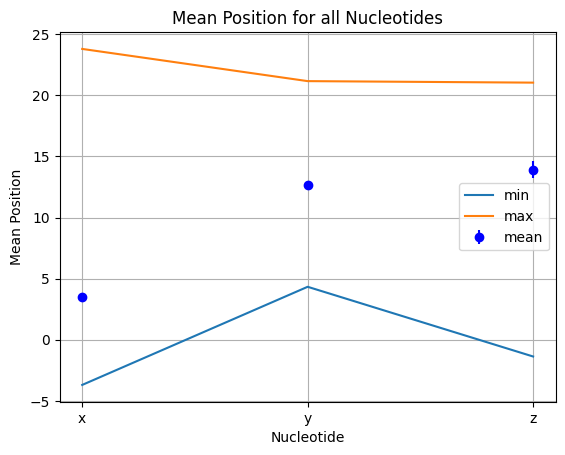

In [107]:
computePlotStatsAll(posAll, "Position")

In [ ]:
computePlotStatsAll(baseAll, "Base Vector")

In [ ]:
computePlotStatsAll(baseNormalAll, "Base Normal Vector")

In [ ]:
computePlotStatsAll(velocityAll, "Velocity")

In [ ]:
computePlotStatsAll(angVelocityAll, "Angular Velocity")

## Acceleration Data Analysis

In [ ]:
velocityAll.shape

In [ ]:
# stats over accln
dt = 0.005
acclnAll = []
angAcclnAll = []

# iterate over nucleotides
# velocityAll = [t, n, c]
for i in range(velocityAll.shape[1]):
    accln = []
    angAccln = []
        
    # iterate over time steps
    for j in range(velocityAll.shape[0]-1):

        v_curr = velocityAll[j, i, :]
        v_next = velocityAll[j+1, i, :]
        a = (v_next - v_curr) / dt
        accln.append(a)

        av_curr = angVelocityAll[j, i, :]
        av_next = angVelocityAll[j+1, i, :]
        av = (av_next - av_curr) / dt
        angAccln.append(av)

    acclnAll.append(accln)
    angAcclnAll.append(angAccln)

In [ ]:
_acclnAll = np.array(acclnAll)
acclnAll = np.reshape(_acclnAll, (_acclnAll.shape[1], _acclnAll.shape[0], _acclnAll.shape[2]))
_angAcclnAll = np.array(angAcclnAll)
angAcclnAll = np.reshape(_angAcclnAll, (_angAcclnAll.shape[1], _angAcclnAll.shape[0], _angAcclnAll.shape[2]))
print(acclnAll.shape)
print(angAcclnAll.shape)

In [ ]:
plotSampleTimeData(acclnAll, "Acceleration")

In [ ]:
plotSampleTimeData(angAcclnAll, "Angular Acceleration")

In [ ]:
computePlotStatsPer(acclnAll, "Acceleration")

In [ ]:
computePlotStatsPer(angAcclnAll, "Angular Acceleration")

In [ ]:
computePlotStatsAll(acclnAll, "Acceleration")

In [ ]:
computePlotStatsAll(angAcclnAll, "Angular Acceleration")

## Energy Data Analysis

We can extract the total energy for the system at every time step, so when we want to compute the mean, standard deviation, min, max, etc. we will obtain scalar values as shown below. 

In [9]:
_energyAll = np.array(energyAll)
energyAll = _energyAll[:, 0] # E = Etot U K -- we just want Etot
energyAll.shape

(1000,)

In [14]:
mean_E, std_E, min_E, max_E = computeStatsPer(energyAll)
print("mean = {0:.3f}".format(mean_E))
print("std dev = {0:.3f}".format(std_E))
print("min = {0:.3f}".format(min_E))
print("max = {0:.3f}".format(max_E))

mean = -1.330
std dev = 0.034
min = -1.430
max = -1.250


## Bounding Box Analysis
I think that the bounding box remains constant throughout the simulation but this will help me check that assumption is correct. 

In [18]:
bbAll = np.array(bbAll)
bbAll.shape

(1000, 3)

In [23]:
mean_per, std_per, min_per, max_per = computeStatsPer(bbAll)
mean_bb, std_bb, min_bb, max_bb = computeStatsAll(mean_per, std_per, min_per, max_per)

In [24]:
print("mean = {0:.3f}".format(mean_bb))
print("std dev = {0:.3f}".format(std_bb))
print("min = {0:.3f}".format(min_bb))
print("max = {0:.3f}".format(max_bb))

mean = 20.000
std dev = 0.000
min = 20.000
max = 20.000


Yes confirmed that the bounding box is constant.

## CoM Position vs. Base Vector

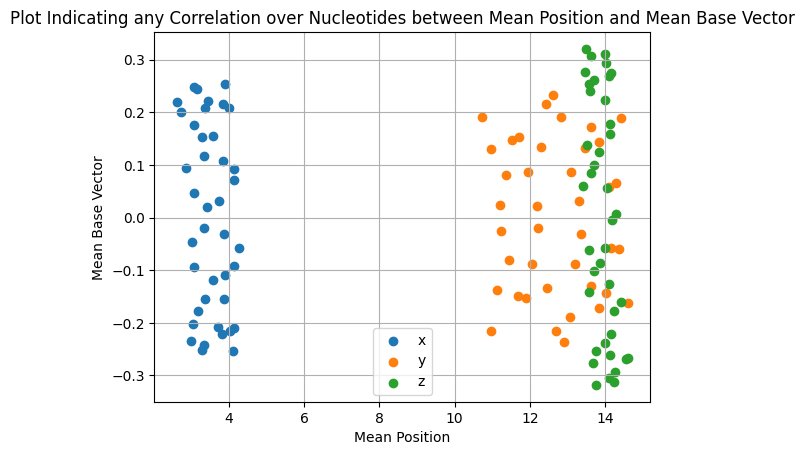

In [62]:
plotCorrelation(posAll, baseAll, axis=0, data1label="Mean Position", data2label="Mean Base Vector")

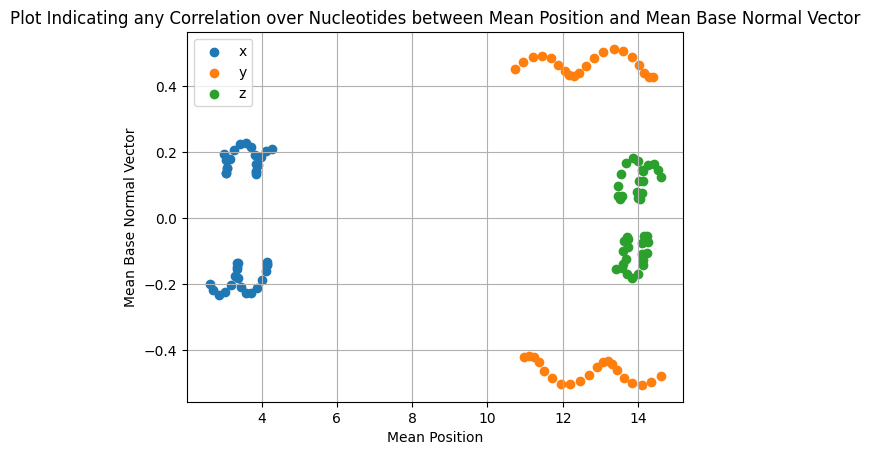

In [65]:
plotCorrelation(posAll, baseNormalAll, axis=0, data1label="Mean Position", data2label="Mean Base Normal Vector")

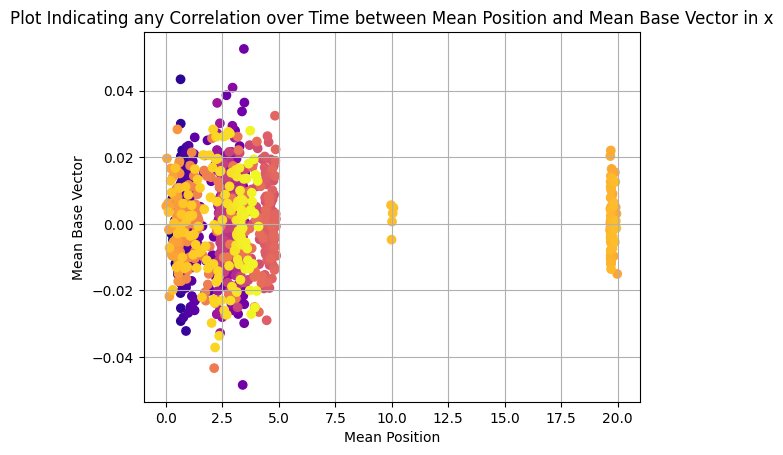

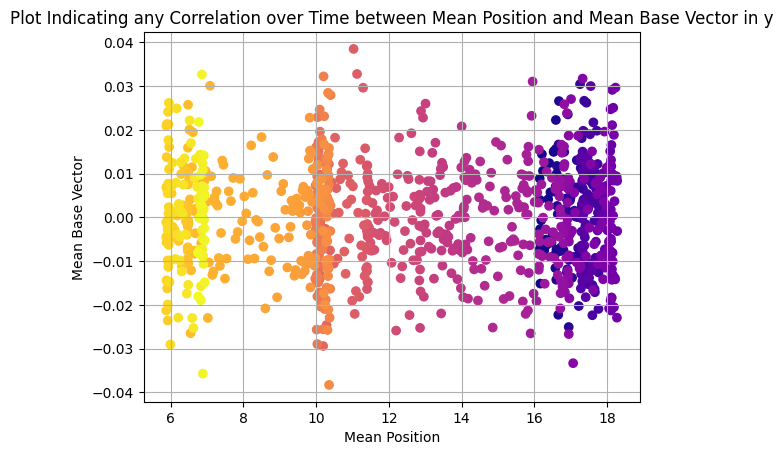

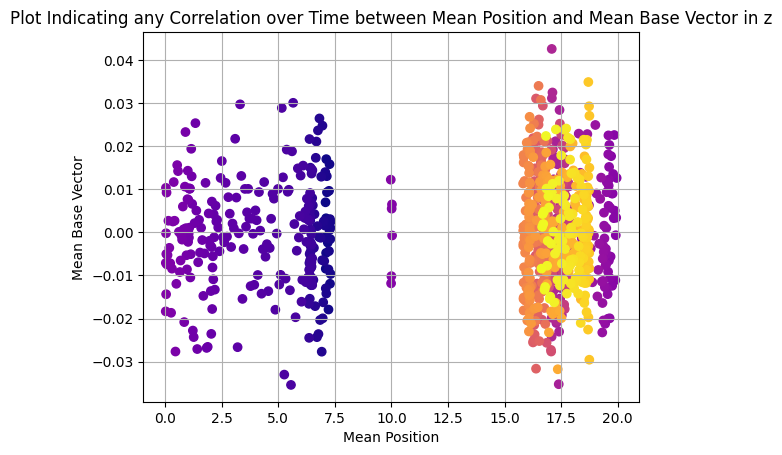

In [70]:
plotCorrelation(posAll, baseAll, axis=1, data1label="Mean Position", data2label="Mean Base Vector")

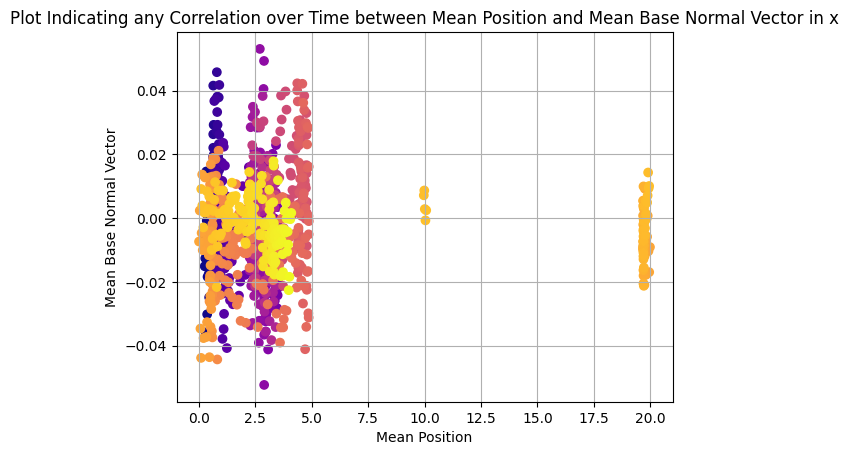

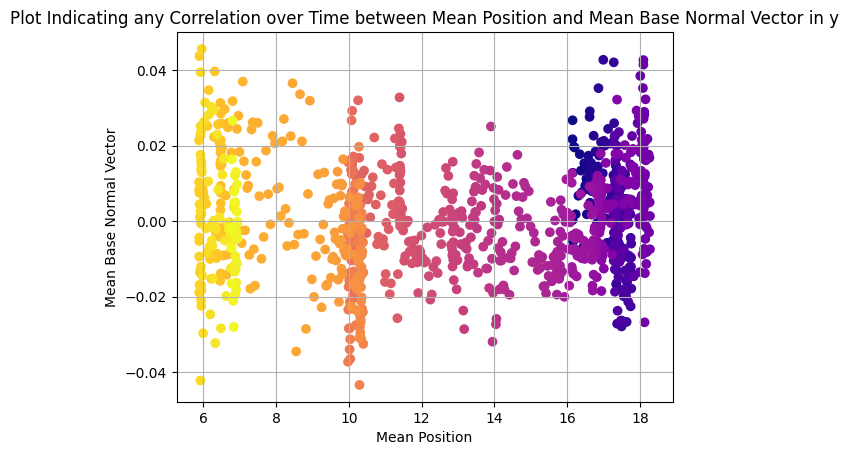

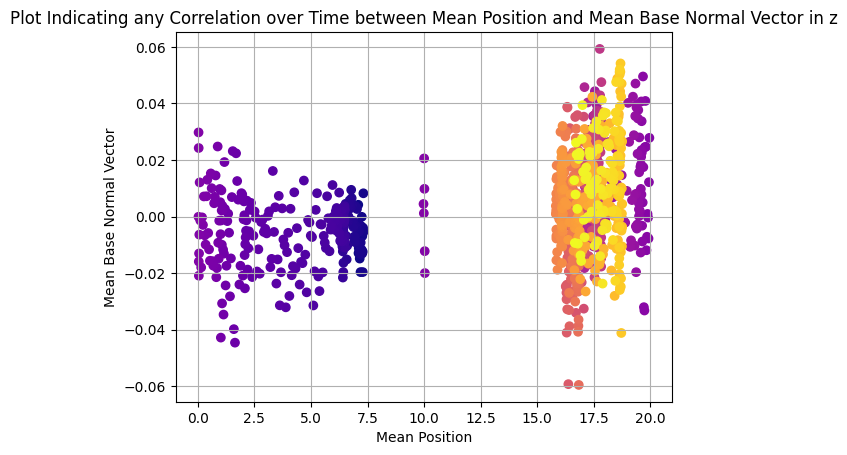

In [71]:
plotCorrelation(posAll, baseNormalAll, axis=1, data1label="Mean Position", data2label="Mean Base Normal Vector")

## Velocity vs. Angular Velocity

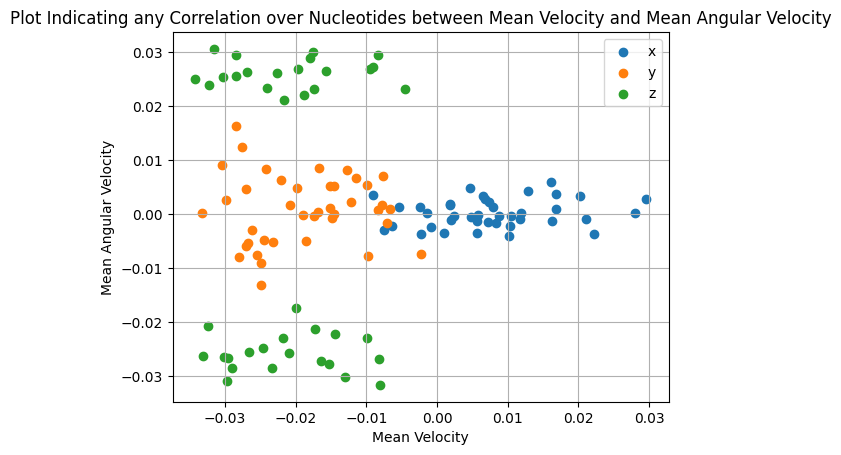

In [75]:
plotCorrelation(velocityAll, angVelocityAll, axis=0, data1label="Mean Velocity", data2label="Mean Angular Velocity")

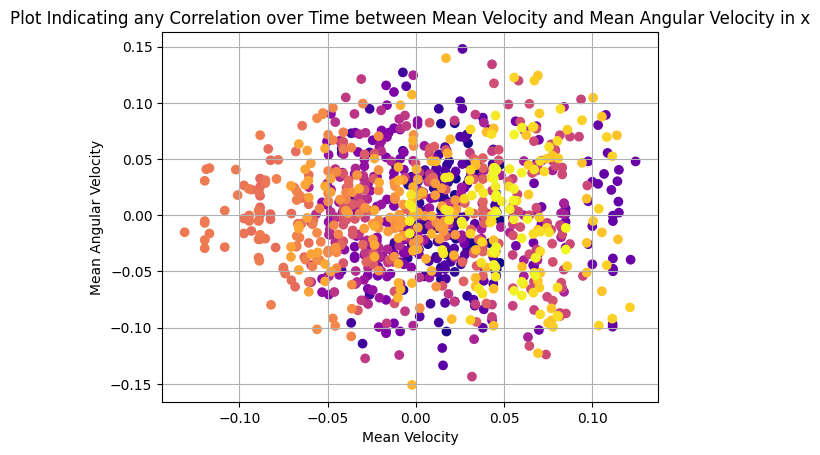

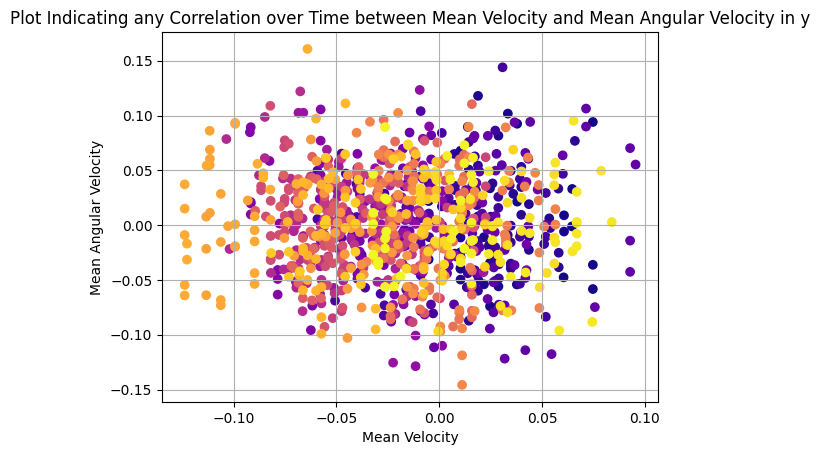

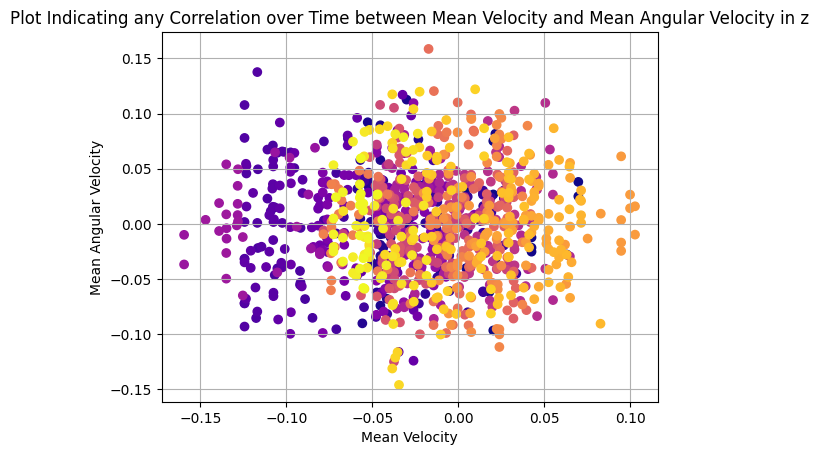

In [76]:
plotCorrelation(velocityAll, angVelocityAll, axis=1, data1label="Mean Velocity", data2label="Mean Angular Velocity")